In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
for dirname, _, filenames in os.walk('/dev/kaggle/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/dev/kaggle/data\submission4.csv
/dev/kaggle/data\amazon-employee-access-challenge\sampleSubmission.csv
/dev/kaggle/data\amazon-employee-access-challenge\test.csv
/dev/kaggle/data\amazon-employee-access-challenge\train.csv


In [6]:
import warnings
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import xgboost as xgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use(style='ggplot')
%matplotlib inline

In [7]:
train = pd.read_csv('data/amazon-employee-access-challenge/train.csv')
test = pd.read_csv('data/amazon-employee-access-challenge/test.csv')

test_id = test['id']

In [8]:
print(test.shape)
test.head()

(58921, 10)


,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


### Exploration
    ACTION: 자원이 승인된 경우 1 아닌경우 0
    RESOURCE: 각 리소스 ID
    MGR_ID: 현재 EMPLOYEE ID 레코드 관리자의 EMPLOYEE ID
    ROLE_ROLLUP_1: Company role grouping category id 1 
                   (e.g. US Engineering).
    ROLE_ROLLUP_2: Company role grouping category id 2 
                   (e.g. US Retail).
    ROLE_DEPTNAME: Company role department description 
                   (e.g. Retail).
    ROLE_TITLE: Company role business title description 
                (e.g. Senior Engineering Retail Manager).
    ROLE_FAMILY_DESC: Company role family extended description 
                      (e.g. Retail Manager, Software Engineering).
    ROLE_FAMILY: Company role family description 
                 (e.g. Retail Manager).
    ROLE_CODE: Company role code

In [9]:
print(train.shape)
print(train.isnull().sum())
train.info()

(32769, 10)
ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [10]:
print(test.shape)
print(test.isnull().sum())
test.info()

(58921, 10)
id                  0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                58921 non-null  int64
 1   RESOURCE          58921 non-null  int64
 2   MGR_ID            58921 non-null  int64
 3   ROLE_ROLLUP_1     58921 non-null  int64
 4   ROLE_ROLLUP_2     58921 non-null  int64
 5   ROLE_DEPTNAME     58921 non-null  int64
 6   ROLE_TITLE        58921 non-null  int64
 7   ROLE_FAMILY_DESC  58921 non-null  int64
 8   ROLE_FAMILY       58921 non-null  int64
 9   ROLE_CODE         58921 non-null  int64
dtypes: int64(10)
memory usage: 4.5 MB


----------Box Plots for detecting outliers---------


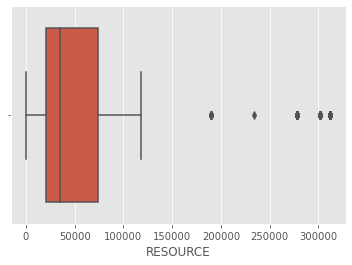

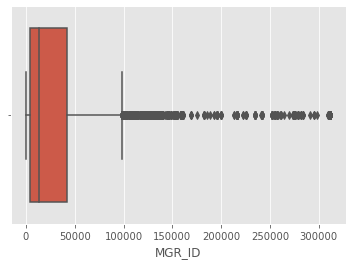

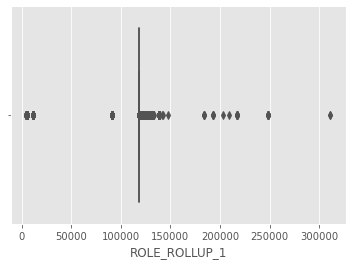

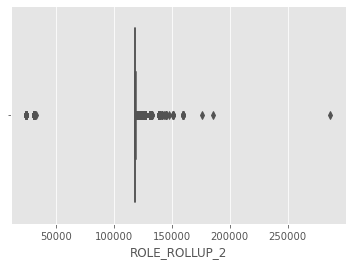

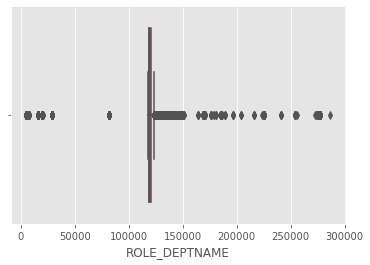

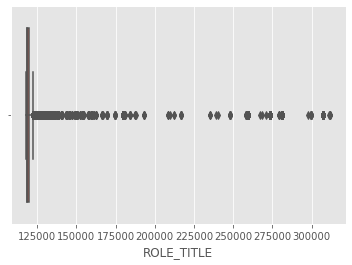

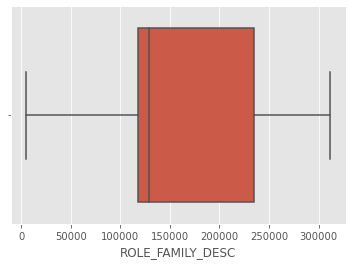

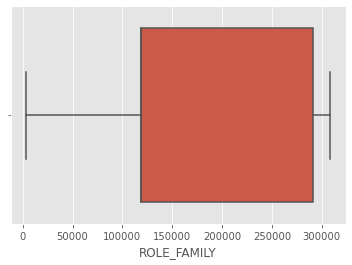

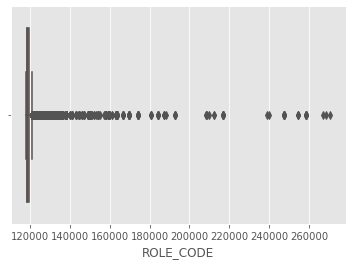

In [11]:
print("----------Box Plots for detecting outliers---------")
target = "ACTION"
cols = [x for x in train.columns if x!=target]
for i in cols:
    plt.figure()
    sns.boxplot(train[i])

### EDA

In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ACTION,32769.0,0.942110,0.233539,0.0,1.0,1.0,1.0,1.0
RESOURCE,32769.0,42923.916171,34173.892702,0.0,20299.0,35376.0,74189.0,312153.0
MGR_ID,32769.0,25988.957979,35928.031650,25.0,4566.0,13545.0,42034.0,311696.0
ROLE_ROLLUP_1,32769.0,116952.627788,10875.563591,4292.0,117961.0,117961.0,117961.0,311178.0
ROLE_ROLLUP_2,32769.0,118301.823156,4551.588572,23779.0,118102.0,118300.0,118386.0,286791.0
ROLE_DEPTNAME,32769.0,118912.779914,18961.322917,4674.0,118395.0,118921.0,120535.0,286792.0
ROLE_TITLE,32769.0,125916.152644,31036.465825,117879.0,118274.0,118568.0,120006.0,311867.0
ROLE_FAMILY_DESC,32769.0,170178.369648,69509.462130,4673.0,117906.0,128696.0,235280.0,311867.0
ROLE_FAMILY,32769.0,183703.408893,100488.407413,3130.0,118363.0,119006.0,290919.0,308574.0
ROLE_CODE,32769.0,119789.430132,5784.275516,117880.0,118232.0,118570.0,119348.0,270691.0


<AxesSubplot:>

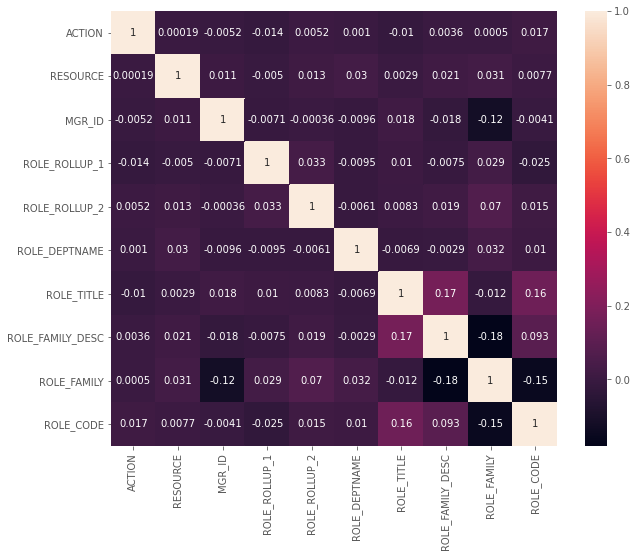

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(), annot=True)

In [14]:
train['RESOURCE'][:10]

0    39353
1    17183
2    36724
3    36135
4    42680
5    45333
6    25993
7    19666
8    31246
9    78766
Name: RESOURCE, dtype: int64

<Figure size 648x432 with 0 Axes>

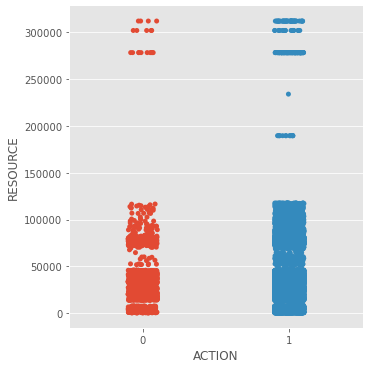

In [15]:
plt.figure(figsize=(9, 6))
sns.catplot('ACTION', 'RESOURCE', data=train)

In [16]:
train['MGR_ID'][:10]

0    85475
1     1540
2    14457
3     5396
4     5905
5    14561
6    17227
7     4209
8      783
9    56683
Name: MGR_ID, dtype: int64

<Figure size 648x432 with 0 Axes>

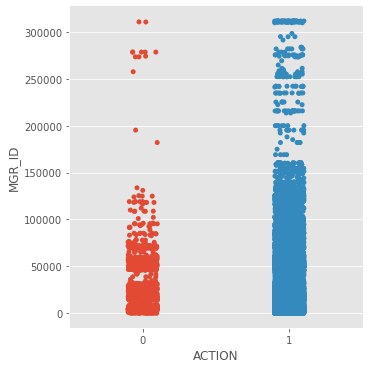

In [17]:
plt.figure(figsize=(9, 6))
sns.catplot('ACTION', 'MGR_ID', data=train)

In [18]:
temp = pd.DataFrame(columns=['is_MGR_ID_BiggerThan150000'], dtype=np.float32)
train = pd.concat([train, temp], axis=1)
for i in range(train.shape[0]):
    try:
        if train['MGR_ID'][i] > 150000:
            train['is_MGR_ID_BiggerThan150000'][i] = 1
        else:
            train['is_MGR_ID_BiggerThan150000'][i] = 0
    except Exception:
        train['is_MGR_ID_BiggerThan150000'][i] = 0
        pass
    
    
temp = pd.DataFrame(columns=['is_MGR_ID_BiggerThan150000'], dtype=np.float32)
test = pd.concat([test, temp], axis=1)
for i in range(test.shape[0]):
    try:
        if test['MGR_ID'][i] > 150000:
            test['is_MGR_ID_BiggerThan150000'][i] = 1
        else:
            test['is_MGR_ID_BiggerThan150000'][i] = 0
    except Exception:
        test['is_MGR_ID_BiggerThan150000'][i] = 0
        pass

In [19]:
train['ROLE_ROLLUP_1'][:10]

0    117961
1    117961
2    118219
3    117961
4    117929
5    117951
6    117961
7    117961
8    117961
9    118079
Name: ROLE_ROLLUP_1, dtype: int64

<Figure size 864x864 with 0 Axes>

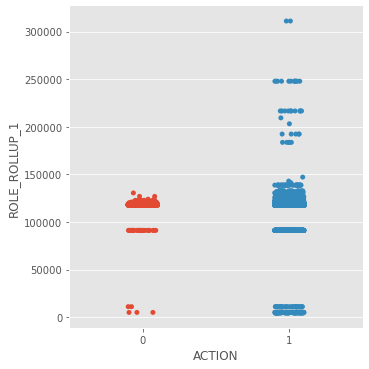

In [20]:
plt.figure(figsize=(12, 12))
sns.catplot('ACTION', 'ROLE_ROLLUP_1', data=train)

In [21]:
temp = pd.DataFrame(columns=['is_ROLE_ROLLUP_1_BiggerThan150000'], dtype=np.float32)
train = pd.concat([train, temp], axis=1)
for i in range(train.shape[0]):
    try:
        if train['ROLE_ROLLUP_1'][i] > 150000:
            train['is_ROLE_ROLLUP_1_BiggerThan150000'][i] = 1
        else:
            train['is_ROLE_ROLLUP_1_BiggerThan150000'][i] = 0
    except Exception:
        train['is_ROLE_ROLLUP_1_BiggerThan150000'][i] = 0
        pass
    
temp = pd.DataFrame(columns=['is_ROLE_ROLLUP_1_BiggerThan150000'], dtype=np.float32)
test = pd.concat([test, temp], axis=1)
for i in range(test.shape[0]):
    try:
        if test['ROLE_ROLLUP_1'][i] > 150000:
            test['is_ROLE_ROLLUP_1_BiggerThan150000'][i] = 1
        else:
            test['is_ROLE_ROLLUP_1_BiggerThan150000'][i] = 0
    except Exception:
        test['is_ROLE_ROLLUP_1_BiggerThan150000'][i] = 0
        pass

In [22]:
train['ROLE_ROLLUP_2'][:10]

0    118300
1    118343
2    118220
3    118343
4    117930
5    117952
6    118343
7    117969
8    118413
9    118080
Name: ROLE_ROLLUP_2, dtype: int64

In [23]:
train['ROLE_ROLLUP_2'].value_counts()

118300    4424
118343    3945
118327    2641
118225    2547
118386    1796
          ... 
141222       1
32137        1
120355       1
118775       1
120018       1
Name: ROLE_ROLLUP_2, Length: 177, dtype: int64

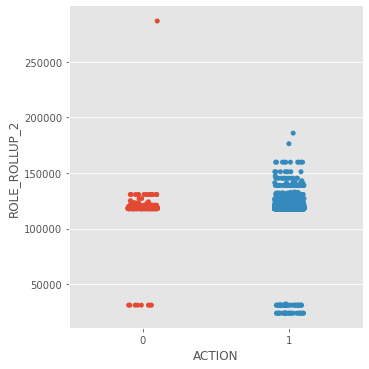

In [24]:
sns.catplot('ACTION', 'ROLE_ROLLUP_2', data=train)

In [25]:
temp = pd.DataFrame(columns=['is_ROLE_ROLLUP_2_BiggerThan140000'], dtype=np.float32)
train = pd.concat([train, temp], axis=1)
for i in range(train.shape[0]):
    try:
        if train['ROLE_ROLLUP_2'][i] > 140000:
            train['is_ROLE_ROLLUP_2_BiggerThan140000'][i] = 1
        else:
            train['is_ROLE_ROLLUP_2_BiggerThan140000'][i] = 0
    except Exception:
        train['is_ROLE_ROLLUP_2_BiggerThan140000'][i] = 0
        pass
    
temp = pd.DataFrame(columns=['is_ROLE_ROLLUP_2_BiggerThan140000'], dtype=np.float32)
test = pd.concat([test, temp], axis=1)
for i in range(test.shape[0]):
    try:
        if test['ROLE_ROLLUP_2'][i] > 140000:
            test['is_ROLE_ROLLUP_2_BiggerThan140000'][i] = 1
        else:
            test['is_ROLE_ROLLUP_2_BiggerThan140000'][i] = 0
    except Exception:
        test['is_ROLE_ROLLUP_2_BiggerThan140000'][i] = 0
        pass